# LAB 2 CODES: SPECTROSCOPY

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os 
import astropy
from glob import glob
from astropy.io import fits
from scipy import signal 
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

from scipy.stats import zscore
import scipy

/Users/nicolasvalencia/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## DARK NOISE AND READ NOISE

In [2]:
folder = glob('./fits_files/*')

# read noise for 1000us and 1000001us
read_short = np.zeros((1080,1440,5))
read_long = np.zeros((1080,1440,6))

# dark frames (1000001us)
dark = np.zeros((1080,1440,5))

# indexes for image stacks
d = 0 
r1 = 0 
r2 = 0 

#loop to put files in correct image stack 
for file in folder: 
    names = file.split('/')[2].split('_')
    
    # if names[0] == 'darkframe':
    #     dark[:,:,d] = fits.getdata(file)
    #     d+=1
        
    # if (names[0] == 'whitelight') & (names[1] == '1000us'):
    #     read_short[:,:,r1] = fits.getdata(file)
    #     r1+=1
        
    if (names[0] == 'newflat') & (names[1] == '1000000us'):
        read_long[:,:,r2] = fits.getdata(file)
        r2+=1

# need to truncate data before calculating any stats from the stack 
dark = dark[525:625,:,:]
read_long = read_long[525:625,:,:]
read_short = read_short[525:625,:,:] 


read_long_noise = np.std(read_long,axis=2)
read_short_noise = np.std(read_short,axis=2)
dark_noise = np.mean(dark,axis=2)

read_long_hdu = fits.PrimaryHDU(read_long_noise)
read_long_hdu.writeto('read_long.fits',overwrite=True)

# read_short_hdu = fits.PrimaryHDU(read_short_noise)
# read_short_hdu.writeto('read_short.fits',overwrite=True)

# dark_noise_hdu = fits.PrimaryHDU(dark_noise)
# dark_noise_hdu.writeto('dark.fits',overwrite=True)

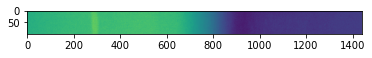

In [279]:
plt.imshow(np.mean(read_long,axis=2))
plt.show()

## 1D SPECTROSCOPY ANALYSIS

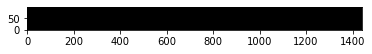

In [3]:
folder = glob('./fits_files/*')
# folder = glob('./sun_photos/*')


# number of images taken for that element, gotta check this each time!!!
num = 6
elements = np.zeros((1080,1440,num))
neon = np.zeros((1080,1440,num))
krypton = np.zeros((1080,1440,num))
mercury = np.zeros((1080,1440,num))


# code to make stack for spec analysis 
ind  = 0 
ind2 = 0 
ind3 = 0 
for file in folder: 
    # print(file)
    names = file.split('/')[2].split('_')
    filetype = names[2].split('.')[1]
    
    # change name and integration time for each different element!!!
    if (names[0] == 'newkrypton'): #& (names[1] == '500001us'):
        if filetype == 'fits':
            krypton[:,:,ind] = fits.getdata(file)
            ind+=1
    # change name and integration time for each different element!!!
    if (names[0] == 'newneon'): #& (names[1] == '500001us'):
        if filetype == 'fits':
            neon[:,:,ind] = fits.getdata(file)
            ind2+=1
    # change name and integration time for each different element!!!
    if (names[0] == 'mercury'): #& (names[1] == '500001us'):
        if filetype == 'fits':
            mercury[:,:,ind] = fits.getdata(file)
            ind3+=1
        
elements = elements[525:625,:,:]
element = np.mean(elements,axis=2)
# norm = ImageNormalize(element, vmin=0, vmax=100, stretch=SqrtStretch())

neonmean = np.mean(neon[525:625,:,:],axis=2)
kryptonmean = np.mean(krypton[525:625,:,:],axis=2)
mercurymean = np.mean(mercury[525:625,:,:],axis=2)


#test to see if mean image was created
plt.imshow(element, cmap='gist_heat', origin='lower')
plt.show()

In [5]:
from scipy.fft import fft,ifft


# set up x axis and further cleaning element data into 1d spectrum
x = range(0,element.shape[1])
flat = fits.getdata('./read_long.fits')
# element = element - flat

element_1d = np.mean(kryptonmean,axis=0)

neon_1d = np.mean(neonmean,axis=0)
krypton_1d = np.mean(kryptonmean,axis=0)
mercury_1d = np.mean(mercurymean,axis=0)




y = linear_cleaner(element_1d,1)
peaks,props = signal.find_peaks(y,threshold=0.1,distance=10,width=30)

# # deconvoultion of intensity

# element_f = fft(element_1d/np.max(element_1d))
# # intensity_f = fft(intensity/np.max(intensity),n=len(element_1d))

# # decon = element_f / (intensity_f + 1e-8) 

# element_inv = np.real(ifft(decon))

# # element_cleanint = element_1d/(intensity/np.max(intensity))






# # plt.figure(figsize=(12,8))
# plt.plot(x,element_1d,label='1D Signal')
# plt.plot(x,y,label='cleaned spectrum')
# plt.plot(x,element_inv,label='clean')
# plt.plot(x,(element_1d/intensity)/np.max(element_1d/intensity),label='clean')
# plt.plot(x,intensity/np.max(intensity))
# plt.plot(x,element_cleanint)

# plt.plot(peaks,y[peaks],'o',c='red')
# plt.ylim(700,1000)

# plt.xlabel('Pixel Number (Row Px)',fontsize=15)
# plt.ylabel('Intensity (ADU)',fontsize=15)
# plt.title('1D Emission Spectra of Krypton',fontsize=25)
# # plt.title('1D spectrum for mer')
# # plt.ylim(-1,1)
# plt.legend(prop={'size': 15})
# # plt.savefig('./plots/krypton_1d.png')
# plt.show()

# peaks


In [6]:
known_peaks = np.array([278,1004,1084])
wavelengths = np.array([546,576,579])

# Fit a polynomial to the data
polynomial_coefficients = np.polyfit(known_peaks, wavelengths, 1)  # linear right now, can be changed 

# polynomial function based on fit
polynomial = np.poly1d(polynomial_coefficients)

# convert pixel numbers to wavelengths using the polynomial
pixel_number = 100
pixel_data = np.arange(0,element.shape[0], 100)

wavelength_angstrom = polynomial(pixel_number) * 10





print(f"Pixel {pixel_number} corresponds to {wavelength_angstrom:.2f} Å")

polynomial(pixel_data)

pixels = np.arange(0,element_1d.shape[0], 200)


Pixel 100 corresponds to 5387.00 Å


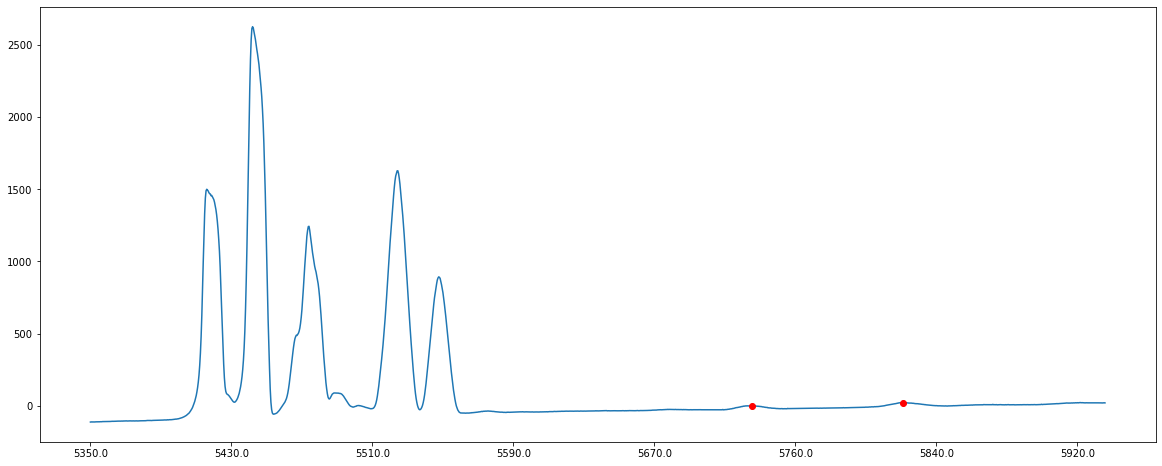

In [7]:
# plotting the data
plt.figure(figsize=(20,8))
# plt.plot(x,element_1d)
plt.plot(x,y)
plt.plot(peaks,y[peaks],'o',c='red')
plt.xticks(ticks=pixels,labels=np.round(polynomial(pixels))*10)

# plt.ylim(700,1000)
plt.show()



In [67]:
def linear_cleaner(signal,std):
    '''
    find linear fit to a signal and remove it from original signal, 
    ignoring outliers (spikes) in the data
    written by N Valencia and ChatGPT
    '''
    signal_cleaned = np.copy(signal)
    zscores = zscore(signal)
    outliers = np.abs(zscores) > std
    
    signal_cleaned[outliers] = np.nan
    x = np.linspace(0,len(signal),signal.shape[0])
    
    # fit polynomial to data without outliers
    valid_idx = ~np.isnan(signal_cleaned)
    fit_coeffs = np.polyfit(x[valid_idx], signal_cleaned[valid_idx], 2)

    # remove polynomial trend from signal
    linear_trend = np.polyval(fit_coeffs,x)
    detrended_signal = signal - linear_trend
    
    return detrended_signal 

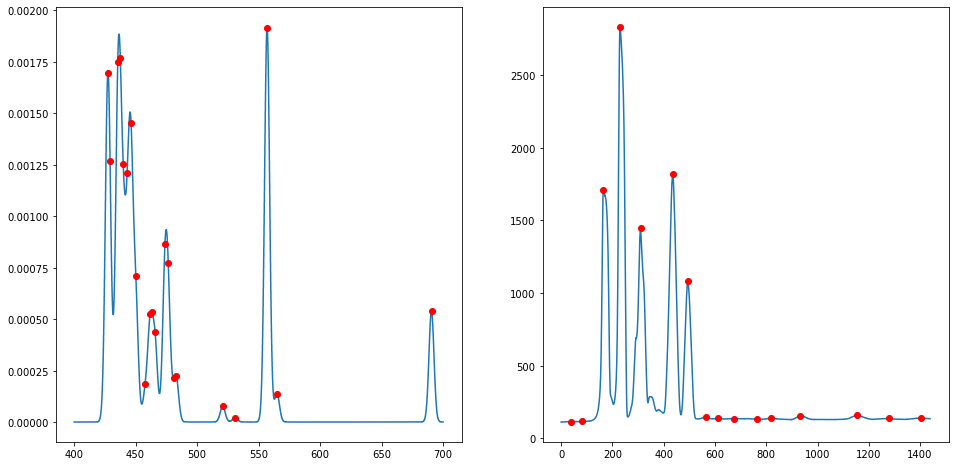

[ 1366  1461  1774  1877  1996  2155  2315  2508  2883  3092  3166  3291
  3692  3825  4055  4157  6038  6540  7848  8244 14520]
[427.4 429.3 435.5 437.6 440.  443.2 446.4 450.2 457.7 461.9 463.4 465.9
 473.9 476.6 481.2 483.2 520.8 530.9 557.  564.9 690.5]
[  38   81  165  230  310  436  494  564  613  675  764  819  931 1153
 1280 1404]


In [8]:
# ms = np.loadtxt('./mercury.asc')
ms = np.loadtxt('./krypton.asc')
# ms = np.loadtxt('./neon.asc')


# cut data to wavelength window 
# truncated = (ms[:,0] > 400) & (ms[:,0] < 600) # mercury attempt 2 
truncated = (ms[:,0] > 400) & (ms[:,0] < 700) # krypton attempt 1
# truncated = (ms[:,0] > 400) & (ms[:,0] < 550) # neon attempt 1


ms = ms[truncated]

# cut out spikes that dont show in detector (unknown why not)
spikes = ms[:,1] > 0.06
ms[spikes,1] = 0 

# ms[500:600,1] = 0 

# cut out section of wavelengths that doesnt behave with standard data
cutout = (ms[:,0] > 580) & (ms[:,0] < 600)
ms[cutout,1] = 0 



peaks_st,props_st = signal.find_peaks(ms[:,1],threshold=0.000001,distance=10,width=15)
peaks_el,props_el = signal.find_peaks(element_1d,threshold=0.0001,distance=40,width=2)



plt.figure(figsize=(16,8))
plt.subplot(1,2,1)   
# plt.plot(ms[:,0],ms[:,1])
# ms = ms[,:]
filtered = scipy.ndimage.gaussian_filter1d(ms[:,1],sigma=100)

plt.plot(ms[:,0],filtered)
plt.plot(ms[peaks_st,0],filtered[peaks_st],'o',c='red')

# plt.xlim(400,600)
# plt.ylim(0,0.08)

plt.subplot(1,2,2)
plt.plot(x,element_1d,label='1d signal')
# plt.plot(x,element_cleanint,label='cleaned up')

plt.plot(peaks_el,element_1d[peaks_el],'o',c='red')
# plt.ylim(0,750)



plt.show()

print(peaks_st)
print(ms[peaks_st,0])
print(peaks_el)


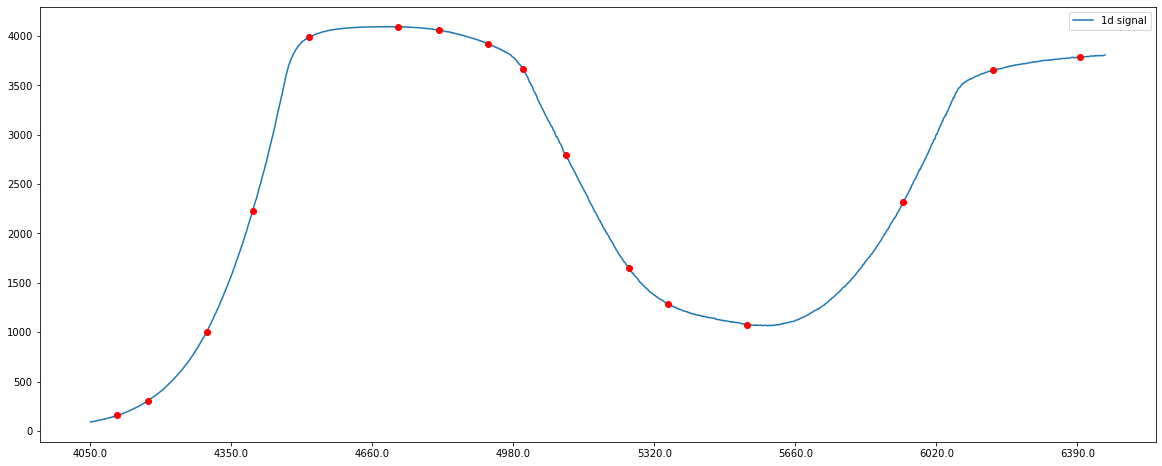

[1.50323751e-05 1.45993157e-01 4.05382361e+02]


In [42]:
mercury_pks = [278,1004,1084]
mercury_wls = [436,546,578]    # attempt 2


neon_pks = [546,788,1250,1365] 
neon_wls = [503.8,534.1,614.1,639.8] 

krypton_pks = [165,230,310,436,494] 
krypton_wls = [427.4,435.5,461.9,473.9,483.2] 

data_pks = np.concatenate((krypton_pks,mercury_pks,neon_pks))
data_wls = np.concatenate((krypton_wls,mercury_wls,neon_wls))

# mercury_wls = [365,546,578]  # attempt 1 

# Fit a polynomial to the data
polynomial_coefficients = np.polyfit(data_pks, data_wls, 2)  # linear right now, can be changed 
polynomial = np.poly1d(polynomial_coefficients)
pixels = np.arange(0,element_1d.shape[0], 200)


# plotting the data
plt.figure(figsize=(20,8))
# plt.plot(x,y)
plt.plot(x,element_1d,label='1d signal')
plt.plot(peaks_el,element_1d[peaks_el],'o',c='red')
plt.xticks(ticks=pixels,labels=np.round(polynomial(pixels))*10)
plt.legend()

# plt.ylim(700,1000)
plt.show()

print(polynomial_coefficients)

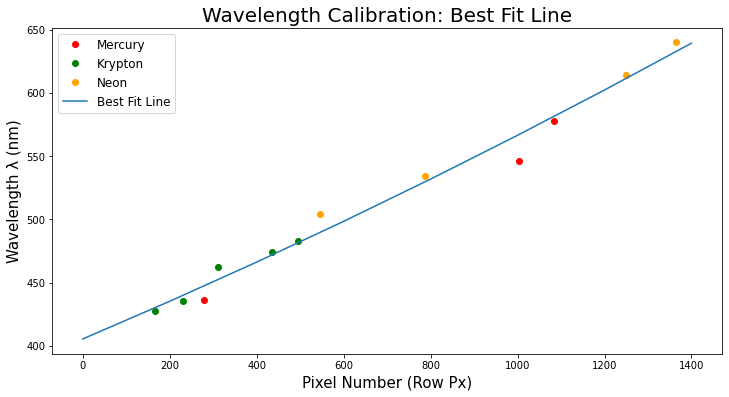

In [54]:
# code above should constrain wavelength resolution of system using mercury 

plt.figure(figsize=(12,6))
plt.plot(mercury_pks,mercury_wls,'o',label='Mercury',c='r')
plt.plot(krypton_pks,krypton_wls,'o',label='Krypton',c='green')
plt.plot(neon_pks,neon_wls,'o',label='Neon',c='orange')

plt.plot(pixels,polynomial(pixels),label='Best Fit Line')
plt.xlabel('Pixel Number (Row Px)',fontsize=15)
plt.ylabel('Wavelength λ (nm)',fontsize=15)
plt.title('Wavelength Calibration: Best Fit Line',fontsize=20)
plt.legend(prop={'size': 12})
plt.show()
# plt.savefig('./plots/wavelength_calibration_bestfit.png')

In [ ]:
# sigma for krypton is 50 
# sigma for mercury is 200, tbh doesnt matter for this one 

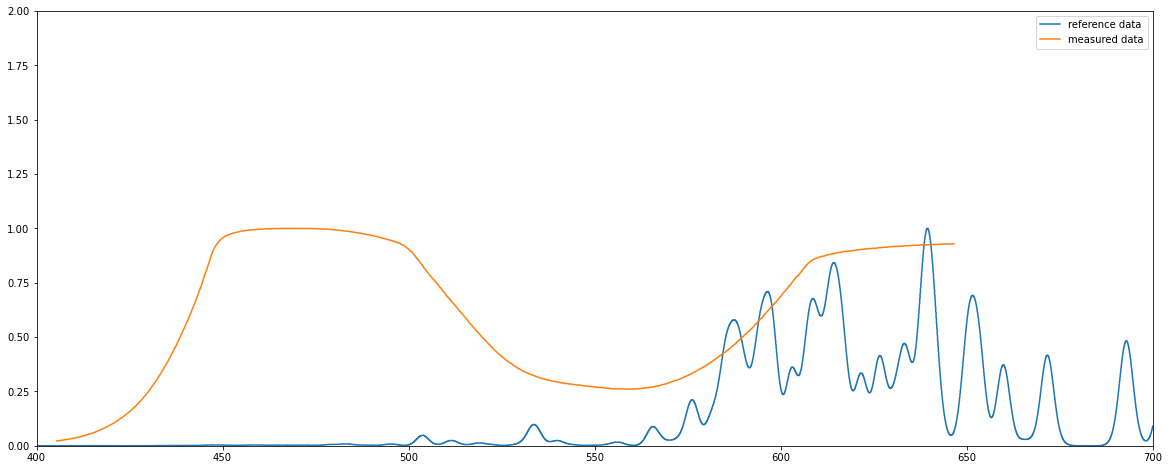

[ 5869  7464  8069 12008 13014 14046 15290 16045 16755 17770 18384 19978
 25397 28725 29817 30784 31603 34699]
[315.3 347.2 359.3 438.1 458.2 478.9 503.8 518.9 533.1 553.4 565.6 597.5
 705.9 772.5 794.3 813.6 830.  891.9]
[418]


In [55]:
### one plot, using initial wavelength calibration guess to help 

# ms = np.loadtxt('./mercury.asc')
# ms = np.loadtxt('./krypton.asc')
ms = np.loadtxt('./neon.asc')


# cut data to wavelength window 
# truncated = (ms[:,0] > 400) & (ms[:,0] < 650) # mercury attempt 2 
# truncated = (ms[:,0] > 400) & (ms[:,0] < 700) # krypton attempt 1
truncated = (ms[:,0] > 450) & (ms[:,0] < 635) # neon attempt 1


# ms = ms[truncated]

# cut out spikes that dont show in detector (unknown why not)
spikes = ms[:,1] > 0.06
ms[spikes,1] = 0 

# ms[500:600,1] = 0 

# cut out section of wavelengths that doesnt behave with standard data
cutout = (ms[:,0] > 580) & (ms[:,0] < 600)
# ms[cutout,1] = 0 



peaks_st,props_st = signal.find_peaks(ms[:,1],threshold=0.000001,distance=600,width=15)
peaks_el,props_el = signal.find_peaks(element_1d,threshold=0.001,distance=20,width=20)



plt.figure(figsize=(20,8))
# plt.subplot(1,2,1)   
# plt.plot(ms[:,0],ms[:,1])
# ms = ms[,:]
filtered = scipy.ndimage.gaussian_filter1d(ms[:,1],sigma=80)

filtered = filtered / np.max(filtered)
element_1d = element_1d / np.max(element_1d)

plt.plot(ms[:,0],filtered*1,label='reference data' )
plt.plot(polynomial(x),element_1d,label='measured data')
# plt.plot(polynomial(x)-16,element_cleanint/np.max(element_cleanint),label='cleaned up measured data')


# plt.plot(x,element_1d,label='1d signal')
# plt.plot(peaks_el,element_1d[peaks_el],'o',c='red')
# plt.plot(ms[peaks_st,0],filtered[peaks_st],'o',c='red')


plt.xlim(400,700)
plt.ylim(0,2)
plt.legend()
plt.show()

print(peaks_st)
print(ms[peaks_st,0])
print(peaks_el)


## Sun and sky analysis 

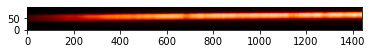

In [57]:
folder = glob('./sun_photos/*')
# folder = glob('./newflats/*')



# number of images taken for that element, gotta check this each time!!!
num = 6
elements = np.zeros((1080,1440,num))

# code to make stack for spec analysis 
ind = 0 
for file in folder: 
    # print(file)
    names = file.split('/')[2].split('_')
    filetype = names[2].split('.')[1]
    
    # change name and integration time for each different element!!!
    if (names[0] == 'sun'): #& (names[1] == '500001us'):
        if filetype == 'fits':
            elements[:,:,ind] = fits.getdata(file)
            ind+=1
        
elements = elements[525:625,:,:]
element = np.mean(elements,axis=2)
# norm = ImageNormalize(element, vmin=0, vmax=100, stretch=SqrtStretch())


#test to see if mean image was created
plt.imshow(element, cmap='gist_heat', origin='lower')
plt.show()

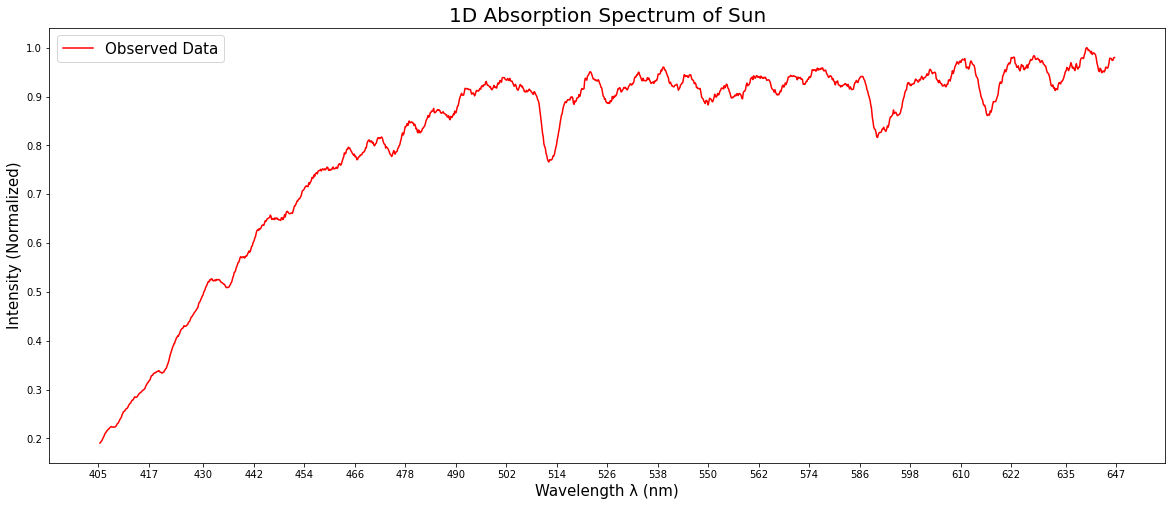

In [109]:
# set up x axis and further cleaning element data into 1d spectrum
x = range(0,element.shape[1])
flat = fits.getdata('./read_long.fits')
# element = element - flat

element_1d = np.mean(element,axis=0)
# intensity = np.mean(element,axis=0)



y = linear_cleaner(element_1d,2)
peaks,props = signal.find_peaks(y,threshold=0.1,distance=10,width=30)


# plotting the data
plt.figure(figsize=(20,8))
plt.plot(polynomial(x),element_1d/np.max(element_1d),label='Observed Data',c='r')
# plt.plot(polynomial(x),((y+200)/np.max((y+200))),label='Cleaned Data',c='b')
# plt.plot(polynomial(x),y)
# plt.plot(peaks,y[peaks],'o',c='red')
# plt.ylim(700,1000)

# plt.xlabel('pixel nu')
# plt.ylabel('Intensity')
plt.ylabel('Intensity (Normalized)',fontsize=15)
plt.xlabel('Wavelength λ (nm)',fontsize=15)
plt.xticks(np.round(np.linspace(polynomial(x)[0],polynomial(x)[-1],21)))
plt.title('1D Absorption Spectrum of Sun',fontsize=20)

plt.legend(prop={'size': 15})
# plt.show()
plt.savefig('./plots/sun_1dspectra.png')

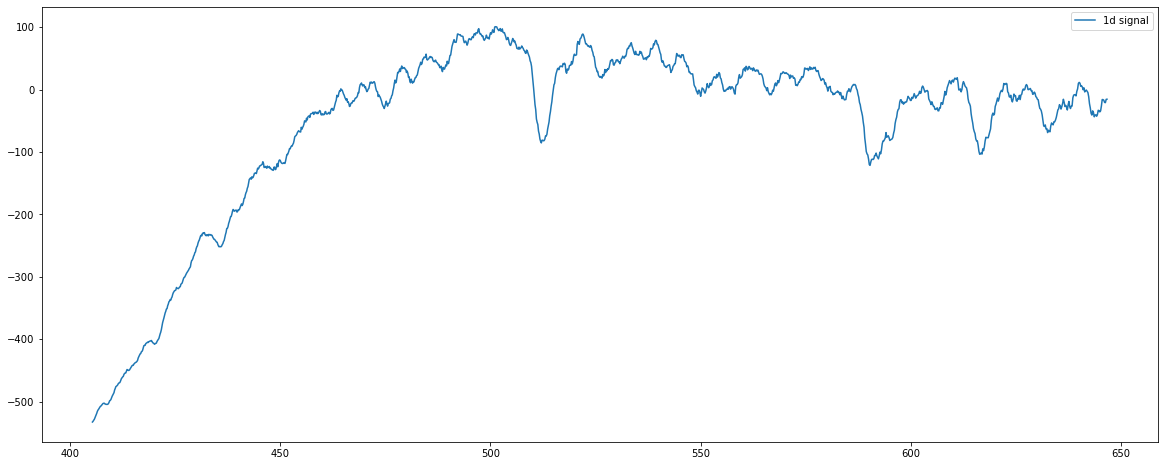

In [59]:
# plotting the data
plt.figure(figsize=(20,8))
# plt.plot(x,y)
# plt.plot(polynomial(x),element_1d/np.max(element_1d),label='1d signal')
plt.plot(polynomial(x),y,label='1d signal')

# plt.plot(peaks_el,element_1d[peaks_el],'o',c='red')
# plt.xticks(ticks=pixels,labels=np.round(polynomial(pixels))*10)
plt.legend()
# plt.vlines(513,ymin=0,ymax=1)
# plt.vlines(590,ymin=0,ymax=1)
# plt.plot(polynomial(x),intensity/np.max(intensity))
# plt.plot(polynomial(x),np.abs((intensity/np.max(intensity))-(element_1d/np.max(element_1d))))

# plt.xlim(400,600)
plt.show()


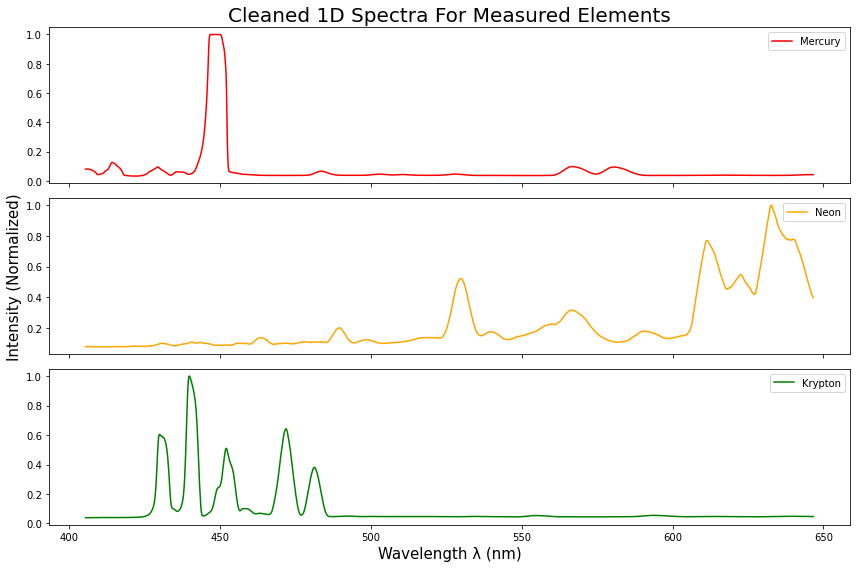

In [35]:
# plotting the data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
fig.subplots_adjust(wspace=0)


ax1.plot(polynomial(x), mercury_1d/np.max(mercury_1d), color='r',label='Mercury')
ax1.set_title('Cleaned 1D Spectra For Measured Elements',fontsize=20)
# ax1.set_ylabel('Intensity (ADU)',fontsize=15)
# ax1.grid(True, which='both')
ax1.legend()

ax2.plot(polynomial(x), neon_1d/np.max(neon_1d), color='orange',label='Neon')
# ax2.set_title('Cosine Wave')
ax2.set_ylabel('Intensity (Normalized)',fontsize=15)
# ax2.grid(True, which='both')
ax2.legend()


ax3.plot(polynomial(x), krypton_1d/np.max(krypton_1d), color='green',label='Krypton')
# ax3.set_title('Tangent Wave')
# ax3.set_ylabel('Intensity (ADU)',fontsize=15)
ax3.set_xlabel(f'Wavelength λ (nm)',fontsize=15)
# ax3.grid(True, which='both')
ax3.legend()


# # Add boxes around each subplot
# for ax in [ax1, ax2, ax3]:
#     ax.spines['top'].set_linewidth(1.5)
#     ax.spines['right'].set_linewidth(1.5)
#     ax.spines['bottom'].set_linewidth(1.5)
#     ax.spines['left'].set_linewidth(1.5)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig('./plots/all_1dspectra.png')